In [32]:
import pandas as pd
import string
import re
import numpy as np
import datetime as dt
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import time
from sklearn.compose import ColumnTransformer

In [19]:
# Read Dataset
all_season_results_df = pd.read_csv('final_game_results.csv')
all_season_results_df.head()

,team1_id,team1_x,season_x,team2,team2_id,game_number_team1_x,game_number_team2,win_flag_team1,season_game_team1_id,season_game_team2_id,...,ft%_team2_opp,game_id_team2,win%_team2,homeaway_win%_team2,b2bbreak_win%_team2,travel_win%_team2,win%_team2_opp,homeaway_win%_team2_opp,b2bbreak_win%_team2_opp,travel_win%_team2_opp
0,1,ATLANTA HAWKS,1999,NEW JERSEY NETS,20,3,2,0,ATLANTA HAWKS-1999-3,NEW JERSEY NETS-1999-2,...,0.800000,NEW JERSEY NETS-1999-2,0.00,0.000000,0.000000,0.0,1.000000,0.000000,1.00,0.000000
1,1,ATLANTA HAWKS,1999,CHICAGO BULLS,6,4,3,1,ATLANTA HAWKS-1999-4,CHICAGO BULLS-1999-3,...,0.812857,CHICAGO BULLS-1999-3,0.50,0.000000,0.500000,0.5,0.666667,0.000000,1.00,0.000000
2,1,ATLANTA HAWKS,1999,CHARLOTTE HORNETS,5,5,5,1,ATLANTA HAWKS-1999-5,CHARLOTTE HORNETS-1999-5,...,0.725852,CHARLOTTE HORNETS-1999-5,0.25,0.000000,0.000000,0.0,0.750000,1.000000,1.00,0.500000
3,1,ATLANTA HAWKS,1999,PHILADELPHIA 76ERS,26,6,5,0,ATLANTA HAWKS-1999-6,PHILADELPHIA 76ERS-1999-5,...,0.593750,PHILADELPHIA 76ERS-1999-5,0.75,0.666667,0.666667,0.5,0.800000,0.500000,1.00,0.666667
4,1,ATLANTA HAWKS,1999,CHICAGO BULLS,6,7,6,1,ATLANTA HAWKS-1999-7,CHICAGO BULLS-1999-6,...,0.709501,CHICAGO BULLS-1999-6,0.20,0.000000,0.200000,0.0,0.666667,0.333333,0.75,0.500000


In [20]:
# Keep important features
all_season_results_df_final = all_season_results_df[['game_number_team2', 'win_flag_team1',
       'ortg_team1', 'ast%_team1', 'ts%_team1', 'efg%_team1', 'poss_team1',
       'dreb%_team1', 'oreb%_team1', 'stl%_team1', 'blk%_team1', 'tov%_team1',
       'ft%_team1', 'win%_roll8_team1', 'ortg_team1_opp', 'ast%_team1_opp',
       'ts%_team1_opp', 'efg%_team1_opp', 'poss_team1_opp', 'dreb%_team1_opp',
       'oreb%_team1_opp', 'stl%_team1_opp', 'blk%_team1_opp', 'tov%_team1_opp',
       'ft%_team1_opp', 'win%_team1', 'homeaway_win%_team1',
       'b2bbreak_win%_team1', 'travel_win%_team1', 'win%_team1_opp',
       'homeaway_win%_team1_opp', 'b2bbreak_win%_team1_opp',
       'travel_win%_team1_opp', 'season', 'game_number_team1',
       'ortg_team2', 'ast%_team2', 'ts%_team2', 'efg%_team2', 'poss_team2',
       'dreb%_team2', 'oreb%_team2', 'stl%_team2', 'blk%_team2', 'tov%_team2',
       'ft%_team2', 'win%_roll8_team2', 'ortg_team2_opp', 'ast%_team2_opp',
       'ts%_team2_opp', 'efg%_team2_opp', 'poss_team2_opp', 'dreb%_team2_opp',
       'oreb%_team2_opp', 'stl%_team2_opp', 'blk%_team2_opp', 'tov%_team2_opp',
       'ft%_team2_opp', 'win%_team2', 'homeaway_win%_team2',
       'b2bbreak_win%_team2', 'travel_win%_team2', 'win%_team2_opp',
       'homeaway_win%_team2_opp', 'b2bbreak_win%_team2_opp',
       'travel_win%_team2_opp']]

# Separate dataset into features and outcome
X = all_season_results_df_final.drop(['win_flag_team1'], axis=1)
Y = all_season_results_df_final.win_flag_team1

In [21]:
# Imputing for missing data and normalizing the data set 
def num_pipeline_transformer(data):
    numerics = ['float64', 'int64']
    num_attrs = data.select_dtypes(include=numerics)
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ])
    return num_attrs, num_pipeline


def pipeline_transformer(data):
    
    num_attrs, num_pipeline = num_pipeline_transformer(data)
  
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, list(num_attrs))
        ])
    df = full_pipeline.fit_transform(data)
    return df    

In [22]:
# Apply preprocessing transformations into feature dataset
X = pipeline_transformer(X)

In [23]:
# Split data into train and test sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=0)

In [25]:
# Hyperparameter tuning using RandomizedSearchCV
# Gradient Boosting Classifier  

param_grid_gb = {
                'loss': ['deviance', 'exponential'],
                'learning_rate': [0.01, 0.1, 1],
                'n_estimators': [50,70,90],
                'max_depth': [5, 10, 15]
                 }
classifier_gb = GradientBoostingClassifier(random_state = 0,max_features = 'sqrt')
grid_search = RandomizedSearchCV(classifier_gb, param_grid_gb,
                           return_train_score=True,
                           scoring = 'precision',
                           cv=5,
                           verbose = 2,
                           iid=False
                          )

grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=90, max_depth=5, loss=deviance, learning_rate=1 ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=90, max_depth=5, loss=deviance, learning_rate=1, total=  14.8s
[CV] n_estimators=90, max_depth=5, loss=deviance, learning_rate=1 ....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s remaining:    0.0s


[CV]  n_estimators=90, max_depth=5, loss=deviance, learning_rate=1, total=  14.9s
[CV] n_estimators=90, max_depth=5, loss=deviance, learning_rate=1 ....
[CV]  n_estimators=90, max_depth=5, loss=deviance, learning_rate=1, total=  14.5s
[CV] n_estimators=90, max_depth=5, loss=deviance, learning_rate=1 ....
[CV]  n_estimators=90, max_depth=5, loss=deviance, learning_rate=1, total=  14.8s
[CV] n_estimators=90, max_depth=5, loss=deviance, learning_rate=1 ....
[CV]  n_estimators=90, max_depth=5, loss=deviance, learning_rate=1, total=  14.6s
[CV] n_estimators=70, max_depth=10, loss=deviance, learning_rate=1 ...
[CV]  n_estimators=70, max_depth=10, loss=deviance, learning_rate=1, total=  22.9s
[CV] n_estimators=70, max_depth=10, loss=deviance, learning_rate=1 ...
[CV]  n_estimators=70, max_depth=10, loss=deviance, learning_rate=1, total=  22.8s
[CV] n_estimators=70, max_depth=10, loss=deviance, learning_rate=1 ...
[CV]  n_estimators=70, max_depth=10, loss=deviance, learning_rate=1, total=  22.

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 21.0min finished
/opt/conda/envs/springboard/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                  

In [26]:
# Identify best parameters
grid_search.best_params_

{'n_estimators': 70,
 'max_depth': 10,
 'loss': 'deviance',
 'learning_rate': 0.01}

In [27]:
# Print precision with assciated parameters
cv_scores = grid_search.cv_results_
##printing all the parameters along with their scores
for mean_score, params in zip(cv_scores['mean_test_score'], cv_scores["params"]):
    print(mean_score, params)

0.6102441929219005 {'n_estimators': 90, 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 1}
0.6113964283853159 {'n_estimators': 70, 'max_depth': 10, 'loss': 'deviance', 'learning_rate': 1}
0.6573464193787704 {'n_estimators': 90, 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.01}
0.659497298507075 {'n_estimators': 70, 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.1}
0.6175670518327825 {'n_estimators': 50, 'max_depth': 15, 'loss': 'deviance', 'learning_rate': 1}
0.6503179321245013 {'n_estimators': 70, 'max_depth': 15, 'loss': 'deviance', 'learning_rate': 0.1}
0.6565994189752077 {'n_estimators': 70, 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.01}
0.6579725328915709 {'n_estimators': 90, 'max_depth': 15, 'loss': 'exponential', 'learning_rate': 0.01}
0.661244317040737 {'n_estimators': 70, 'max_depth': 10, 'loss': 'deviance', 'learning_rate': 0.01}
0.6175670518327825 {'n_estimators': 70, 'max_depth': 15, 'loss': 'deviance', 'learning_rate': 1}


In [28]:
# feature importances 
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.01022449, 0.01429757, 0.00895311, 0.00965389, 0.01084328,
       0.00788402, 0.00848909, 0.00771642, 0.01062916, 0.00972617,
       0.00934753, 0.00923132, 0.01235653, 0.01134994, 0.00938915,
       0.00902225, 0.00903406, 0.00814454, 0.00823793, 0.00809132,
       0.00977086, 0.01066521, 0.00953245, 0.00912468, 0.03312168,
       0.06716621, 0.01467234, 0.02229455, 0.03144514, 0.05522051,
       0.0188981 , 0.02164743, 0.00409504, 0.00971322, 0.01740961,
       0.00938489, 0.01105746, 0.01228861, 0.00817115, 0.0082054 ,
       0.00827764, 0.01053618, 0.0101358 , 0.00981477, 0.00935113,
       0.01382381, 0.01186563, 0.00992649, 0.00923892, 0.00926782,
       0.00863958, 0.00763383, 0.0078189 , 0.00896409, 0.01017154,
       0.0090323 , 0.00879667, 0.03679555, 0.05372504, 0.02329381,
       0.01756444, 0.03337144, 0.05889543, 0.01707399, 0.0194789 ])

              precision    recall  f1-score   support

           0       0.67      0.65      0.66      5087
           1       0.66      0.68      0.67      5054

    accuracy                           0.66     10141
   macro avg       0.66      0.66      0.66     10141
weighted avg       0.66      0.66      0.66     10141



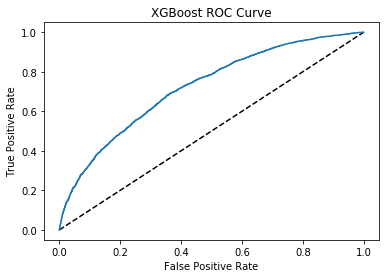

In [34]:
# Display confusion matrix results
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'AUC', 'Time to Train'], 
                       columns=['XG Boost'])
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)
metrics.loc['accuracy', 'XGBoost'] = accuracy_score(y_pred=y_pred, y_true=Y_test)
metrics.loc['precision', 'XGBoost'] = precision_score(y_pred=y_pred, y_true=Y_test)
metrics.loc['recall', 'XGBoost'] = recall_score(y_pred=y_pred, y_true=Y_test)
y_pred_prob = final_model.predict_proba(X_test)[:,1]
metrics.loc['AUC', 'XGBoost'] = roc_auc_score(Y_test, y_pred_prob)
print(classification_report(Y_test, y_pred))

fpr, tpr, thresholds  = roc_curve(Y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % 'XGBoost')
plt.show()

    

In [35]:
# Creating a function to cover this entire flow¶
def predict_game_outcome(config, model):
    
    if type(config) == dict:
        df = pd.DataFrame(config)
    else:
        df = config
    df = df.drop(columns = ['win_flag_team1'])
    pipeline = pipeline_transformer(df)
    prepared_df = pipeline.transform(df)
    y_pred = model.predict(df)
    y_pred_prob = model.predict_proba(df)
    prob = float(y_pred_prob[:,1])
    return "Team 1 has a {}% chance of winning".format(round(prob*100,2))

In [51]:
# Predict on random sample
random_test = all_season_results_df_final[2:3]
random_test

,game_number_team2,win_flag_team1,ortg_team1,ast%_team1,ts%_team1,efg%_team1,poss_team1,dreb%_team1,oreb%_team1,stl%_team1,...,tov%_team2_opp,ft%_team2_opp,win%_team2,homeaway_win%_team2,b2bbreak_win%_team2,travel_win%_team2,win%_team2_opp,homeaway_win%_team2_opp,b2bbreak_win%_team2_opp,travel_win%_team2_opp
2,5,1,101.532954,0.46525,0.517012,0.439174,90.3,0.642365,0.339421,0.089344,...,0.132306,0.725852,0.25,0.0,0.0,0.0,0.75,1.0,1.0,0.5


In [47]:
import pickle

##saving the model
with open("model.bin", 'wb') as f_out:
    pickle.dump(final_model, f_out)
    f_out.close()

In [52]:
##loading the model from the saved file
with open('model.bin', 'rb') as f_in:
    model = pickle.load(f_in)

predict_game_outcome(random_test, model)

'Team 1 has a 57.87% chance of winning'